In [1]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

In [2]:
# Patient file paths
patients = {
    1: ['Data/organized_fcs_data1a.csv', 'Data/organized_fcs_data1b.csv', 'Data/organized_fcs_data1c.csv'],
    2: ['Data/organized_fcs_data2a.csv', 'Data/organized_fcs_data2b.csv', 'Data/organized_fcs_data2c.csv'],
    3: ['Data/organized_fcs_data3a.csv', 'Data/organized_fcs_data3b.csv', 'Data/organized_fcs_data3c.csv'],
    4: ['Data/organized_fcs_data4a.csv', 'Data/organized_fcs_data4b.csv', 'Data/organized_fcs_data4c.csv'],
    5: ['Data/organized_fcs_data5a.csv', 'Data/organized_fcs_data5b.csv', 'Data/organized_fcs_data5c.csv'],
    6: ['Data/organized_fcs_data6a.csv', 'Data/organized_fcs_data6b.csv', 'Data/organized_fcs_data6c.csv'],
    7: ['Data/organized_fcs_data7.csv'],
    8: ['Data/organized_fcs_data8a.csv', 'Data/organized_fcs_data8b.csv', 'Data/organized_fcs_data8c.csv'],
    9: ['Data/organized_fcs_data9a.csv', 'Data/organized_fcs_data9b.csv'],
    10: ['Data/organized_fcs_data10a.csv', 'Data/organized_fcs_data10b.csv', 'Data/organized_fcs_data10c.csv'],
    11: ['Data/organized_fcs_data11.csv'],
    12: ['Data/organized_fcs_data12a.csv', 'Data/organized_fcs_data12b.csv', 'Data/organized_fcs_data12c.csv']
}

In [4]:
def load_patient_data(patient_ids):
    all_data = []
    for pid in patient_ids:
        for file in patients[pid]:
            if os.path.exists(file):
                df = pd.read_csv(file)
                df = df.drop(columns=['Time'])  
                all_data.append(df.astype(np.float32).values)
            else:
                print(f"File not found: {file}")
    if all_data:
        return np.vstack(all_data)
    else:
        return np.empty((0, 14))


In [5]:
# Load healthy and unhealthy data
healthy_cells = load_patient_data([1, 2, 3, 4, 5, 6])
unhealthy_cells = load_patient_data([7, 8, 9, 10, 11, 12])

In [7]:
# Scaling data 
print("Scaling data")
scaler = StandardScaler()
healthy_cells_scaled = scaler.fit_transform(healthy_cells)
unhealthy_cells_scaled = scaler.transform(unhealthy_cells)

Scaling data


In [8]:
# Fitting GMM to scaled healthy cells
print("Fitting GMM to healthy data")
gmm = GaussianMixture(n_components=16, covariance_type='full', random_state=42)
gmm.fit(healthy_cells_scaled)

Fitting GMM to healthy data


GaussianMixture(n_components=16, random_state=42)

In [9]:
# Saving model
joblib.dump(gmm, 'gmm_s_complete_16.pkl')   
print("GMM model saved")

GMM model saved


In [10]:
# Score both healthy & unhealthy cells
print("Scoring cells")
healthy_scores = gmm.score_samples(healthy_cells_scaled)
unhealthy_scores = gmm.score_samples(unhealthy_cells_scaled)

Scoring cells


In [11]:
threshold = np.percentile(healthy_scores, 1) 
print(threshold)

-26.136448652361192


In [12]:
# Detecting anomalies in unhealthy cells
anomalies = unhealthy_scores < threshold
healthy_anomalies = healthy_scores < threshold

In [13]:
#Each patient MRD percentages:
print("\n MRD percentage for each unhealthy patient:")

unhealthy_patient_ids = [7, 8, 9, 10, 11, 12]
start_idx = 0

for pid in unhealthy_patient_ids:
    patient_data = load_patient_data([pid])
    patient_cells = len(patient_data)
    patient_anomalies = anomalies[start_idx:start_idx + patient_cells]
    patient_mrd_percentage = (np.sum(patient_anomalies) / patient_cells) * 100
    print(f"Patient {pid}: {patient_mrd_percentage:.4f}% MRD")
    start_idx += patient_cells


 MRD percentage for each unhealthy patient:
Patient 7: 7.4695% MRD
Patient 8: 1.8178% MRD
Patient 9: 10.9657% MRD
Patient 10: 3.7381% MRD
Patient 11: 16.5328% MRD
Patient 12: 6.3501% MRD


In [14]:
print("\nMRD percentage for each healthy patient (using precomputed anomalies):")

healthy_patient_ids = [1, 2, 3, 4, 5, 6]
start_idx = 0

for pid in healthy_patient_ids:
    patient_data = load_patient_data([pid])
    patient_cells = len(patient_data)
    
    # Use precomputed anomalies
    patient_anomalies = healthy_anomalies[start_idx:start_idx + patient_cells]
    patient_mrd_percentage = (np.sum(patient_anomalies) / patient_cells) * 100
    
    print(f"Patient {pid}: {patient_mrd_percentage:.4f}% MRD")
    
    start_idx += patient_cells



MRD percentage for each healthy patient (using precomputed anomalies):
Patient 1: 1.2840% MRD
Patient 2: 1.0075% MRD
Patient 3: 0.9883% MRD
Patient 4: 1.7977% MRD
Patient 5: 0.2856% MRD
Patient 6: 0.8427% MRD


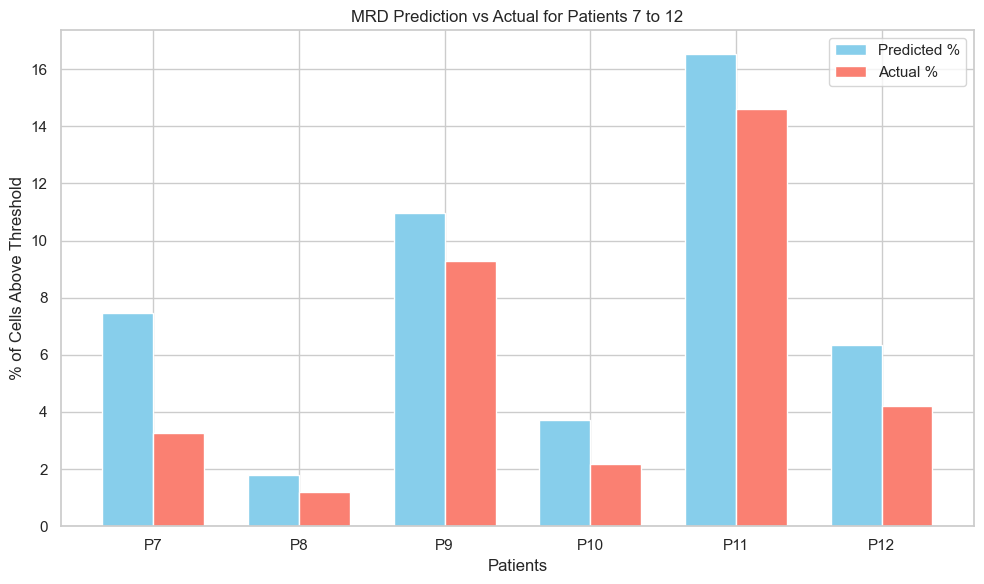

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Patient IDs
patients = ['P7', 'P8', 'P9', 'P10', 'P11', 'P12']

# Predicted percentages by model
predicted_percentages = [7.46,1.81,10.96,3.73,16.53,6.35]  
# Actual percentages
actual_percentages = [3.28, 1.2, 9.3, 2.17, 14.6, 4.2]

# DataFrame for visualization
df_plot = pd.DataFrame({
    'Patient': patients,
    'Predicted': predicted_percentages,
    'Actual': actual_percentages
})

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot bars
bar_width = 0.35
x = np.arange(len(patients))
plt.bar(x - bar_width/2, df_plot['Predicted'], bar_width, label='Predicted %', color='skyblue')
plt.bar(x + bar_width/2, df_plot['Actual'], bar_width, label='Actual %', color='salmon')

# labels and legend
plt.xlabel('Patients')
plt.ylabel('% of Cells Above Threshold')
plt.title('MRD Prediction vs Actual for Patients 7 to 12')
plt.xticks(ticks=x, labels=patients)
plt.legend()
plt.tight_layout()
plt.show()


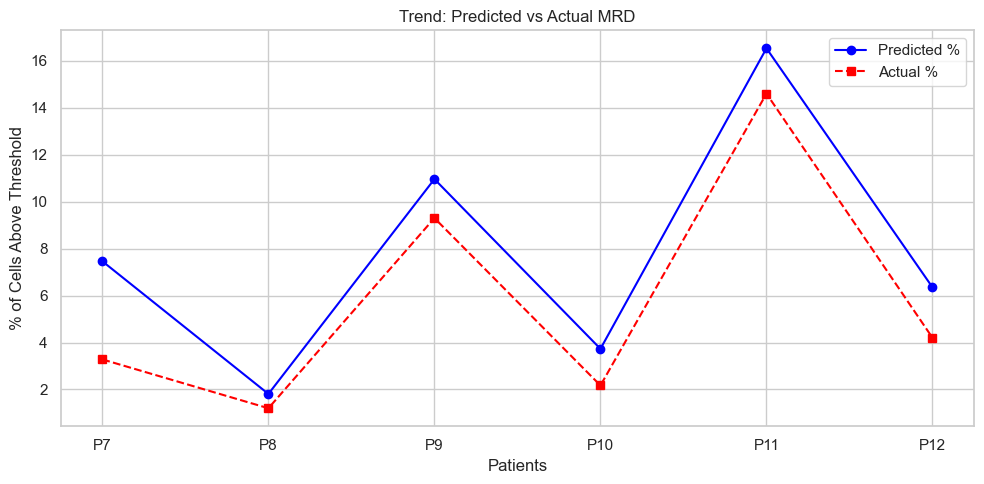

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(patients, predicted_percentages, marker='o', label='Predicted %', linestyle='-', color='blue')
plt.plot(patients, actual_percentages, marker='s', label='Actual %', linestyle='--', color='red')

plt.xlabel('Patients')
plt.ylabel('% of Cells Above Threshold')
plt.title('Trend: Predicted vs Actual MRD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()